# MAE arvutused regressioonide ja otsustuspuuga 

**Teegid**

In [2]:
# arvutamine ja joonistamine
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# treenimine, tulemused
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# regressorid
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# tuunimine
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
#from sklearn.linear_model import RidgeCV
#from sklearn.model_selection import RepeatedKFold

# We don't like warnings
import warnings
warnings.filterwarnings('ignore')

**Andmed ja puhastamine**

In [3]:
# laen treening- ja testandmed
train =  pd.read_csv('df_clean.csv')
test = pd.read_csv('df_clean_test.csv')

In [4]:
train.shape

(8592, 25)

In [5]:
test.shape

(168, 24)

In [6]:
pd.set_option('display.max_columns', 500)
train.head()

,Unnamed: 0,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,coco,el_price,consumption,timestamp,datetime,year,month,day,weekday,hour,date,is_holiday,season,google_trends_electricity
0,0,2021-09-01 00:00:00+03:00,11.2,10.3,94.0,0.0,0.0,320.0,7.2,16.7,1012.6,2.0,0.09016,0.577,2021-09-01 00:00:00,2021-09-01 00:00:00,2021,9,1,2,0,2021-09-01,False,Autumn,5
1,1,2021-09-01 01:00:00+03:00,10.7,9.6,93.0,0.0,0.0,320.0,7.2,13.0,1012.6,2.0,0.09251,0.594,2021-09-01 01:00:00,2021-09-01 01:00:00,2021,9,1,2,1,2021-09-01,False,Autumn,5
2,2,2021-09-01 02:00:00+03:00,9.9,9.0,94.0,0.0,0.0,320.0,7.2,13.0,1012.2,2.0,0.08890,0.685,2021-09-01 02:00:00,2021-09-01 02:00:00,2021,9,1,2,2,2021-09-01,False,Autumn,5
3,3,2021-09-01 03:00:00+03:00,10.0,8.4,90.0,0.0,0.0,330.0,7.2,13.0,1011.9,1.0,0.08735,1.016,2021-09-01 03:00:00,2021-09-01 03:00:00,2021,9,1,2,3,2021-09-01,False,Autumn,5
4,4,2021-09-01 04:00:00+03:00,9.0,8.1,94.0,0.0,0.0,300.0,3.6,13.0,1011.4,2.0,0.08688,0.677,2021-09-01 04:00:00,2021-09-01 04:00:00,2021,9,1,2,4,2021-09-01,False,Autumn,5


In [7]:
train.dtypes

Unnamed: 0                     int64
time                          object
temp                         float64
dwpt                         float64
rhum                         float64
prcp                         float64
snow                         float64
wdir                         float64
wspd                         float64
wpgt                         float64
pres                         float64
coco                         float64
el_price                     float64
consumption                  float64
timestamp                     object
datetime                      object
year                           int64
month                          int64
day                            int64
weekday                        int64
hour                           int64
date                          object
is_holiday                      bool
season                        object
google_trends_electricity      int64
dtype: object

In [8]:
# ühendan (ajutiselt) treening- ja testandmestiku, et viia puhastamine läbi ühise andmestiku peal
train_vahe = train.drop(['consumption'],axis=1)
train_vahe['train']=1
test_vahe = test
test_vahe['train']=0
train_test=pd.concat([train_vahe,test_vahe])

In [9]:
train_test.shape

(8760, 25)

In [10]:
# eemaldan veerud, mida ei vaja analüüsiks
train_test = train_test.drop(columns=['Unnamed: 0', 'time', 'timestamp', 'datetime', 'date'])

In [11]:
# is_holiday booleanist täisarvuks
train_test["is_holiday"] = train_test["is_holiday"].astype(int)

In [12]:
train_test=pd.get_dummies(train_test)

In [13]:
train_test.head()

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,coco,el_price,year,month,day,weekday,hour,is_holiday,google_trends_electricity,train,season_Autumn,season_Spring,season_Summer,season_Winter
0,11.2,10.3,94.0,0.0,0.0,320.0,7.2,16.7,1012.6,2.0,0.09016,2021,9,1,2,0,0,5,1,1,0,0,0
1,10.7,9.6,93.0,0.0,0.0,320.0,7.2,13.0,1012.6,2.0,0.09251,2021,9,1,2,1,0,5,1,1,0,0,0
2,9.9,9.0,94.0,0.0,0.0,320.0,7.2,13.0,1012.2,2.0,0.08890,2021,9,1,2,2,0,5,1,1,0,0,0
3,10.0,8.4,90.0,0.0,0.0,330.0,7.2,13.0,1011.9,1.0,0.08735,2021,9,1,2,3,0,5,1,1,0,0,0
4,9.0,8.1,94.0,0.0,0.0,300.0,3.6,13.0,1011.4,2.0,0.08688,2021,9,1,2,4,0,5,1,1,0,0,0


In [14]:
# normaliseerin andmed
train_test=(train_test-train_test.min())/(train_test.max()-train_test.min())

In [15]:
train_test.describe()

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,coco,el_price,year,month,day,weekday,hour,is_holiday,google_trends_electricity,train,season_Autumn,season_Spring,season_Summer,season_Winter
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,0.575026,0.633145,0.712915,0.002455,0.004836,0.558018,0.288714,0.297010,0.597020,0.191689,0.041149,0.665639,0.502439,0.490700,0.499543,0.500000,0.032877,0.369488,0.980822,0.249429,0.251941,0.252055,0.246575
std,0.162253,0.166682,0.218779,0.031798,0.052988,0.246342,0.152588,0.165456,0.147128,0.198909,0.031501,0.471793,0.313458,0.293248,0.333009,0.300982,0.178324,0.192332,0.137158,0.432707,0.434152,0.434217,0.431042
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.462609,0.520161,0.575000,0.000000,0.000000,0.388889,0.227129,0.168053,0.519435,0.080000,0.023265,0.000000,0.272727,0.233333,0.166667,0.250000,0.000000,0.273684,1.000000,0.000000,0.000000,0.000000,0.000000
50%,0.566957,0.620968,0.787500,0.000000,0.000000,0.583333,0.227129,0.259567,0.614252,0.120000,0.034519,1.000000,0.545455,0.500000,0.500000,0.500000,0.000000,0.305263,1.000000,0.000000,0.000000,0.000000,0.000000
75%,0.692174,0.768145,0.887500,0.000000,0.000000,0.750000,0.340694,0.414309,0.684335,0.200000,0.050003,1.000000,0.818182,0.733333,0.833333,0.750000,0.000000,0.452632,1.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
# eraldan uuesti treening- ja testandmestiku
train_df=train_test[train_test['train']==1]
test_df=train_test[train_test['train']==0]
train_df=train_df.drop(['train'],axis=1)
test_df=test_df.drop(['train'],axis=1)

In [17]:
# lisan treeningandmestikule tagasi 'consumption' atribuudi
train_df = pd.concat([train_df,train['consumption']], axis=1)

In [18]:
train_df.shape

(8592, 23)

In [19]:
test_df.shape

(168, 22)

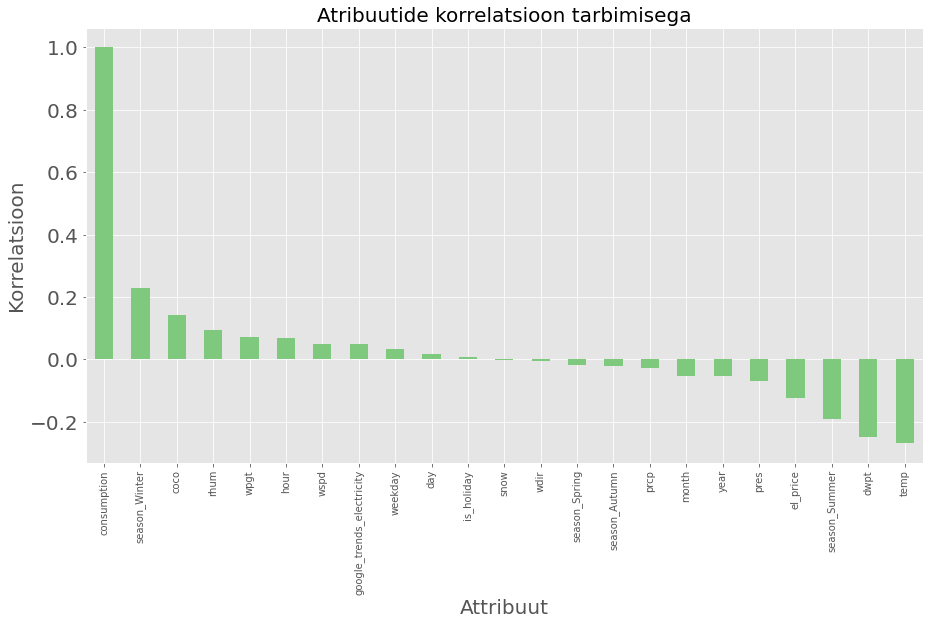

In [20]:
# illustreerin teiste atribuutide korrelatsiooni 'consumption'iga

plt.figure(figsize=(15,8))
plt.style.use('ggplot')

my_cmap = cm.get_cmap('Accent')

train_df.corr()['consumption'].sort_values(ascending = False).plot(kind='bar', cmap=my_cmap)

plt.title('Atribuutide korrelatsioon tarbimisega',fontsize=20)
plt.xlabel('Attribuut', fontsize=20)
plt.ylabel('Korrelatsioon',fontsize=20)

plt.xticks(fontsize = 10) 
plt.yticks(fontsize = 20) 
plt.grid(True)
plt.show() 

**Lineaarregressioon**

In [21]:
y_lr = train_df['consumption']
X_lr = train_df.drop(['consumption'],axis=1)
train_X, val_X, train_y, val_y = train_test_split(X_lr, y_lr,random_state=0, test_size = 0.20)

In [ ]:
model_lr = LinearRegression()
model_lr.fit(train_X, train_y)
val_predictions_lr = model_lr.predict(val_X)

In [ ]:
mean_absolute_error(val_y, val_predictions_lr)

0.6040714330090525

In [ ]:
# katse ristvalideerimisega

model_lr = LinearRegression()

n_folds = 4
fold_MAEs = np.zeros(n_folds)

y = np.array(train_df['consumption'])
X = np.array(train_df.drop(['consumption'], axis = 1))

folds = KFold(n_splits=n_folds, shuffle=True, random_state=0)

folds.get_n_splits(X, y)

fold_indx = 1

for train_index, val_index in folds.split(X, y):
  X_train, X_val = X[train_index], X[val_index]
  y_train, y_val = y[train_index], y[val_index]

  model_lr.fit(X_train, y_train)

  val_predictions = model_lr.predict(X_val)
  fold_MAEs[fold_indx-1] = mean_absolute_error(y_val, val_predictions)

  fold_indx += 1

print(f'Keskmine valideerimisvalimi MAE on {np.mean(fold_MAEs)}') 


Keskmine valideerimisvalimi MAE on 0.6053018360936587


Ristvalideerimine midagi juurde ei andnud, tulemus veidi halvem.

In [ ]:
model_lr = LinearRegression()
model_lr.fit(X_lr, y_lr) #siin ei ole nüüd seda train-test splitti

LinearRegression()

In [ ]:
test_y_ennustused_lr = model_lr.predict(test_df)

In [ ]:
# genereerin Kaggle'i ennustuste faili
submission_lr = pd.DataFrame(
    {'time': test.time, 'consumption': test_y_ennustused_lr},
    columns = ['time', 'consumption'])
#submission_lr.to_csv('submission_lr.csv', index = False)

Kaggle'i tulemuseks andis 0.44184.

**Ridge, Lasso ja ElasticNet regressioonid**

In [ ]:
lambda_ = 1

lr = LinearRegression()
lr_ridge = Ridge(lambda_)
lr_lasso = Lasso(lambda_)
lr_elastic = ElasticNet(alpha = lambda_)

lr.fit(X_lr, y_lr)
lr_ridge.fit(X_lr, y_lr)
lr_lasso.fit(X_lr, y_lr)
lr_elastic.fit(X_lr, y_lr)

predict_lr = lr.predict(val_X)
predict_ridge = lr_ridge.predict(val_X)
predict_lasso = lr_lasso.predict(val_X)
predict_elastic = lr_elastic.predict(val_X)

In [ ]:
mae_lrr = mean_absolute_error(val_y, predict_lr)
print(f'Valideerimisvalimi lineaarregressiooni MAE on {mae_lrr}.')

mae_ridge = mean_absolute_error(val_y, predict_ridge)
print(f'Valideerimisvalimi ridge regressiooni MAE on {mae_ridge}.')

mae_lasso = mean_absolute_error(val_y, predict_lasso)
print(f'Valideerimisvalimi lasso regressiooni MAE on {mae_lasso}.')

mae_elastic = mean_absolute_error(val_y, predict_elastic)
print(f'Valideerimisvalimi elasticnet regressiooni MAE on {mae_elastic}.')


Valideerimisvalimi lineaarregressiooni MAE on 0.6006756380890054.
Valideerimisvalimi ridge regressiooni MAE on 0.6012899604219334.
Valideerimisvalimi lasso regressiooni MAE on 0.6684276661840554.
Valideerimisvalimi elasticnet regressiooni MAE on 0.6684276661840554.


In [ ]:
# genereerin Kaggle'i ennustuste faili RIDGE jaoks
lambda_ = 1 
model_ridge = Ridge(lambda_)
model_ridge.fit(X_lr, y_lr) 
test_y_ennustused_ridge = model_ridge.predict(test_df)

In [ ]:
submission_ridge = pd.DataFrame(
    {'time': test.time, 'consumption': test_y_ennustused_ridge},
    columns = ['time', 'consumption'])
#submission_ridge.to_csv('submission_ridge.csv', index = False)

Kaggle'i tulemuseks andis 0.40911.

In [ ]:
# genereerin Kaggle'i ennustuste faili LASSO jaoks
lambda_ = 1 
model_lasso = Lasso(lambda_)
model_lasso.fit(X_lr, y_lr) 
test_y_ennustused_lasso = model_lasso.predict(test_df)

In [ ]:
submission_lasso = pd.DataFrame(
    {'time': test.time, 'consumption': test_y_ennustused_lasso},
    columns = ['time', 'consumption'])
#submission_lasso.to_csv('submission_lasso.csv', index = False)

Kaggle'i tulemuseks andis 0.59306.

**Ridge tuunimine**

In [ ]:
params = {'alpha': (np.logspace(-8, 8, 100))} # It will check from 1e-08 to 1e+08
lasso = Lasso(normalize=True)
lasso_model = GridSearchCV(lasso, params, cv = 10)
lasso_model.fit(train_X, train_y)
print(lasso_model.best_params_)
print(lasso_model.best_score_)

{'alpha': 1e-08}
0.09600748990189914


In [ ]:
params = {'alpha': (np.logspace(-8, 8, 100))} # It will check from 1e-08 to 1e+08
ridge = Ridge(normalize=True)
ridge_model = GridSearchCV(ridge, params, cv = 10)
ridge_model.fit(train_X, train_y)
print(ridge_model.best_params_)
print(ridge_model.best_score_)

{'alpha': 0.004534878508128591}
0.09612452624040538


In [ ]:
lr_ridge_2 = Ridge(alpha = 0.004534878508128591)
lr_ridge_2.fit(X_lr, y_lr)
predict_ridge_2 = lr_ridge_2.predict(val_X)
mae_ridge_2 = mean_absolute_error(val_y, predict_ridge_2)
print(f'Valideerimisvalimi ridge regressiooni MAE on {mae_ridge_2}.')

Valideerimisvalimi ridge regressiooni MAE on 0.6008612595380223.


In [ ]:
# genereerin Kaggle'i ennustuste faili RIDGE jaoks
model_ridge_2 = Ridge(alpha = 0.004534878508128591)
model_ridge_2.fit(X_lr, y_lr) 
test_y_ennustused_ridge_2 = model_ridge_2.predict(test_df)

In [ ]:
submission_ridge_2 = pd.DataFrame(
    {'time': test.time, 'consumption': test_y_ennustused_ridge_2},
    columns = ['time', 'consumption'])
#submission_ridge_2.to_csv('submission_ridge_2.csv', index = False)

Kaggle: 0.44164, mis ka arusaadav, kuna alpha lähedal nullile ehk sisuliselt lineaarregressioon.

**Otsustuspuu**

In [ ]:
max_depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 30, 40, 50]

error = np.zeros(len(max_depths))

y = np.array(train_df['consumption'])
X = np.array(train_df.drop(['consumption'], axis = 1))

for i, depth in enumerate(max_depths):

  kf = KFold(n_splits=4, random_state=0, shuffle=True)

  fold_mae = []
  for train_index, val_index in kf.split(X):

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model = DecisionTreeRegressor(max_depth = depth)

    model.fit(X_train, y_train) 

    predictions = model.predict(X_val)

    error_mae = mean_absolute_error(y_val, predictions)
    fold_mae.append(error_mae)

  print(f'Keskmine MAE sügavusele {depth} on {np.mean(fold_mae)}.')
  error[i] = np.mean(fold_mae)

Keskmine MAE sügavusele 1 on 0.6096382119397995.
Keskmine MAE sügavusele 2 on 0.6028876863326238.
Keskmine MAE sügavusele 3 on 0.5790933650985635.
Keskmine MAE sügavusele 4 on 0.574374340502702.
Keskmine MAE sügavusele 5 on 0.5546071963106131.
Keskmine MAE sügavusele 6 on 0.5453847699051078.
Keskmine MAE sügavusele 7 on 0.5423273085195697.
Keskmine MAE sügavusele 8 on 0.5391176067147059.
Keskmine MAE sügavusele 9 on 0.5367470758832564.
Keskmine MAE sügavusele 10 on 0.5421660666211173.
Keskmine MAE sügavusele 11 on 0.5506592963997591.
Keskmine MAE sügavusele 12 on 0.5551692172930947.
Keskmine MAE sügavusele 13 on 0.5685044706628031.
Keskmine MAE sügavusele 14 on 0.574522948729862.
Keskmine MAE sügavusele 15 on 0.5836030818750573.
Keskmine MAE sügavusele 20 on 0.602135584192844.
Keskmine MAE sügavusele 30 on 0.6074630567194289.
Keskmine MAE sügavusele 40 on 0.6071945996275605.
Keskmine MAE sügavusele 50 on 0.6026040502793296.


Text(0, 0.5, 'MAE')

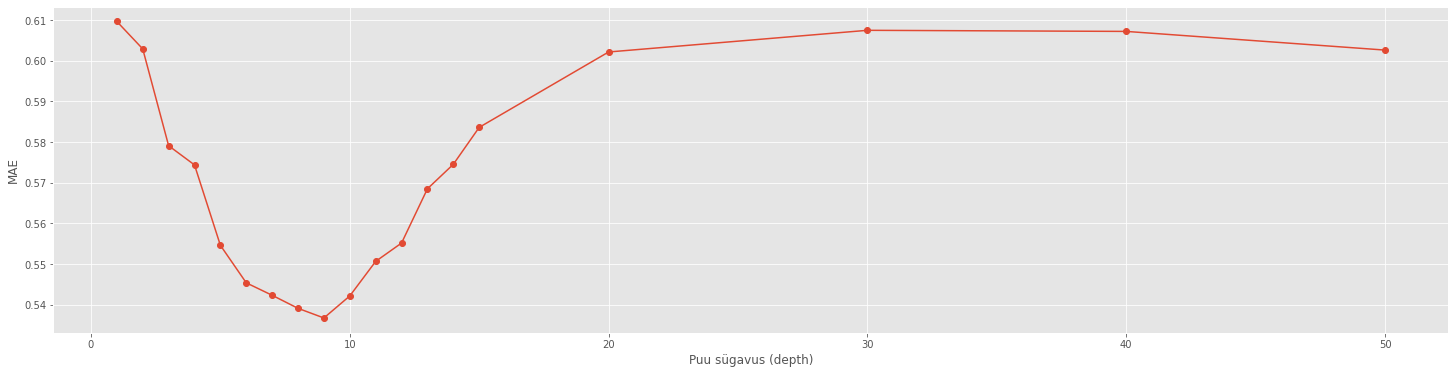

In [ ]:
plt.figure(figsize=(25, 6))

plt.plot(max_depths, error, marker = 'o')
plt.xlabel('Puu sügavus (depth)')
plt.ylabel('MAE')

In [ ]:
model_dt = DecisionTreeRegressor(max_depth = 9)
model_dt.fit(train_X, train_y)

predictions_dt = model_dt.predict(val_X)
mae_dt = mean_absolute_error(val_y, predictions_dt)

print(f'Otsustuspuu MAE on {mae_dt}.')

Otsustuspuu MAE on 0.5013450758961504.


In [ ]:
model_Dt = DecisionTreeRegressor(max_depth = 9)
model_Dt.fit(X_lr, y_lr)

test_y_predictions_dt = model_Dt.predict(test_df)

In [ ]:
submission_dt = pd.DataFrame(
    {'time': test.time, 'consumption': test_y_predictions_dt},
    columns = ['time', 'consumption'])
#submission_dt.to_csv('submission_dt.csv', index = False)

Kaggle'i tulemuseks andis 1.33609. Ju on tegu ülesobitamisega.

**Otsustuspuu tuunimine**

In [ ]:
reg_decision_model=DecisionTreeRegressor()
# fit independent varaibles to the dependent variables
reg_decision_model.fit(train_X, train_y)
predictions_dt_2 = model_dt.predict(val_X)
mean_absolute_error(val_y, predictions_dt_2)

0.5013450758961504

In [ ]:
reg_decision_model.score(train_X,train_y)

1.0

In [ ]:
reg_decision_model.score(val_X,val_y)

0.04662515766791053

In [ ]:
parameters={"splitter":["best","random"],
           "max_depth" : [1,2,3,4,5,6,7,8,9,10,11,12],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] }

In [ ]:
tuning_model=GridSearchCV(reg_decision_model,param_grid=parameters,scoring='neg_mean_absolute_error',cv=3,verbose=3) 

In [ ]:
# function for calculating how much time take for hyperparameter tuning

def timer(start_time=None):
    if not start_time:
        start_time=datetime.now()
        return start_time
    elif start_time:
        thour,temp_sec=divmod((datetime.now()-start_time).total_seconds(),3600)
        tmin,tsec=divmod(temp_sec,60)
        #print(thour,":",tmin,':',round(tsec,2))

In [ ]:
# NB!!! See võtab aega mingi 18-19 minutit!
%%capture
from datetime import datetime

start_time=timer(None)

tuning_model.fit(X_lr,y_lr)

timer(start_time)

In [ ]:
# best hyperparameters 
tuning_model.best_params_

{'max_depth': 11,
 'max_features': 'sqrt',
 'max_leaf_nodes': 50,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf': 0.1,
 'splitter': 'best'}

In [ ]:
tuning_model.best_score_

-0.6048093937316047

In [ ]:
tuned_hyper_model= DecisionTreeRegressor(max_depth=11,max_features='sqrt',max_leaf_nodes=50,min_samples_leaf=1,min_weight_fraction_leaf=0.1,splitter='best')

tuned_hyper_model.fit(X_lr, y_lr)

test_y_predictions_dt_2 = tuned_hyper_model.predict(test_df)

In [ ]:
submission_dt_2 = pd.DataFrame(
    {'time': test.time, 'consumption': test_y_predictions_dt_2},
    columns = ['time', 'consumption'])
submission_dt_2.to_csv('submission_dt_2.csv', index = False)

Kaggle: 0.46657.

**Random Forest**

In [ ]:
nr_trees = [50, 100, 500, 750, 1000]

error = np.zeros(len(nr_trees))

y = np.array(train_df['consumption'])
X = np.array(train_df.drop(['consumption'], axis = 1))

for i, tree in enumerate(nr_trees):

  kf = KFold(n_splits=4, random_state=0, shuffle=True)

  fold_mae = []
  for train_index, val_index in kf.split(X):

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model = RandomForestRegressor(n_estimators = tree)

    model.fit(X_train, y_train) 

    predictions = model.predict(X_val)

    error_mae = mean_absolute_error(y_val, predictions)
    fold_mae.append(error_mae)

  print(f'Keskmine MAE {tree} puule on {np.mean(fold_mae)}')
  error[i] = np.mean(fold_mae)

Keskmine MAE 50 puule on 0.48361642923649906
Keskmine MAE 100 puule on 0.4782721426908752
Keskmine MAE 500 puule on 0.4772387399906891
Keskmine MAE 750 puule on 0.4758865282433271
Keskmine MAE 1000 puule on 0.4758690811219739


Text(0, 0.5, 'MAE')

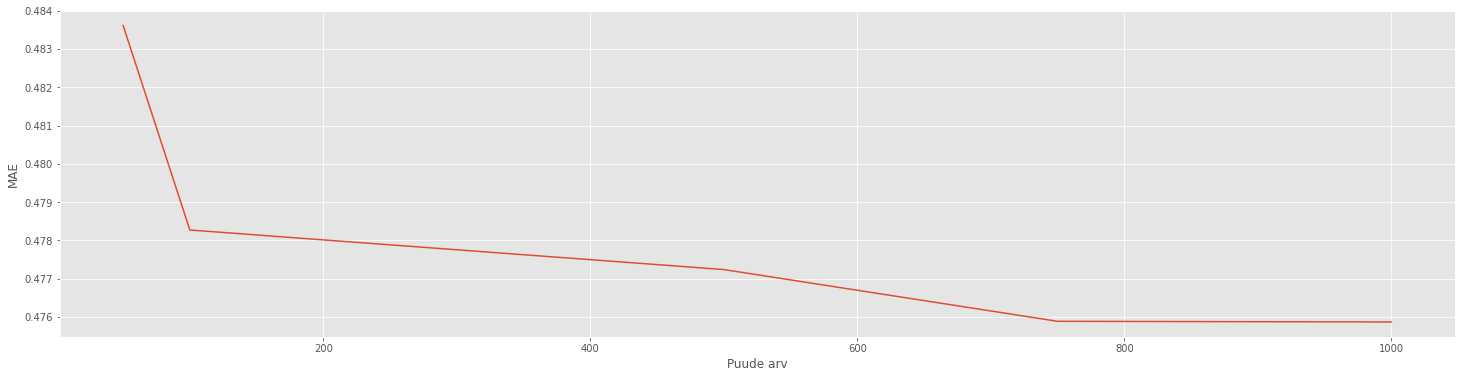

In [ ]:
plt.figure(figsize=(25, 6))

plt.plot(nr_trees, error)
plt.xlabel('Puude arv')
plt.ylabel('MAE')

In [ ]:
model_rf = RandomForestRegressor(n_estimators = 500)
model_rf.fit(train_X, train_y)

predictions_rf = model_rf.predict(val_X)
mae_rf = mean_absolute_error(val_y, predictions_rf) 

print(f'MAE Random Foresti puhul on {mae_rf}')

MAE Random Foresti puhul on 0.46152981966259454


In [ ]:
model_rf = RandomForestRegressor(n_estimators=500)
model_rf.fit(X_lr, y_lr)

test_y_ennustused_rf = model_rf.predict(test_df)

In [ ]:
submission_rf = pd.DataFrame(
    {'time': test.time, 'consumption': test_y_ennustused_rf},
    columns = ['time', 'consumption'])
#submission_rf.to_csv('submission_rf.csv', index = False)

Kaggle'i tulemuseks andis 0.6426.

**Random Forest tuunimine**

In [22]:
model_rf = RandomForestRegressor(n_estimators = 500)
model_rf.fit(train_X, train_y)

predictions_rf = model_rf.predict(val_X)
mae_rf = mean_absolute_error(val_y, predictions_rf) 

print(f'MAE Random Foresti puhul on {mae_rf}')

MAE Random Foresti puhul on 0.46043132751599775


In [24]:
# Get numerical feature importances
importances = list(model_rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(train_X, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: temp                 Importance: 0.15
Variable: el_price             Importance: 0.14
Variable: hour                 Importance: 0.13
Variable: pres                 Importance: 0.09
Variable: dwpt                 Importance: 0.07
Variable: rhum                 Importance: 0.07
Variable: wpgt                 Importance: 0.07
Variable: wdir                 Importance: 0.06
Variable: day                  Importance: 0.05
Variable: weekday              Importance: 0.05
Variable: coco                 Importance: 0.04
Variable: google_trends_electricity Importance: 0.04
Variable: wspd                 Importance: 0.03
Variable: month                Importance: 0.02
Variable: season_Winter        Importance: 0.01
Variable: prcp                 Importance: 0.0
Variable: snow                 Importance: 0.0
Variable: year                 Importance: 0.0
Variable: is_holiday           Importance: 0.0
Variable: season_Autumn        Importance: 0.0
Variable: season_Spring        Importanc

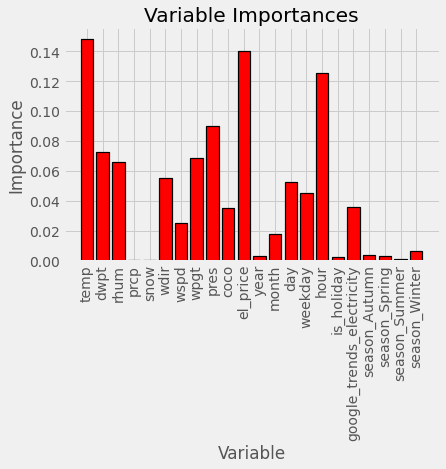

In [26]:
# Reset style 
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)

# Tick labels for x axis
plt.xticks(x_values, train_X, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

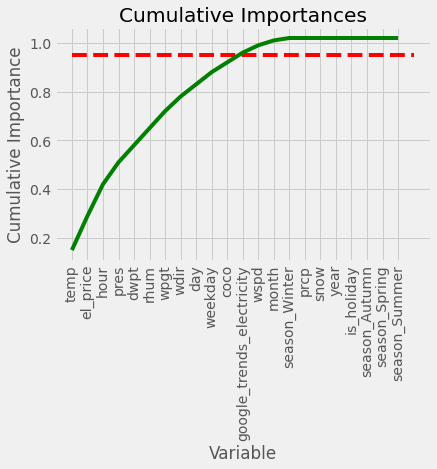

In [27]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

In [28]:
# Find number of features for cumulative importance of 95%
# Add 1 because Python is zero-indexed
print('Number of features for 95% importance:', np.where(cumulative_importances > 0.95)[0][0] + 1)

Number of features for 95% importance: 12


In [42]:
# Extract the names of the most important features
important_feature_names = [feature[0] for feature in feature_importances[0:12]]
important_feature_names

['temp',
 'el_price',
 'hour',
 'pres',
 'dwpt',
 'rhum',
 'wpgt',
 'wdir',
 'day',
 'weekday',
 'coco',
 'google_trends_electricity']

In [46]:
train_X_imp = train_X[train_X.columns.intersection(important_feature_names)]
val_X_imp = val_X[val_X.columns.intersection(important_feature_names)]

In [47]:
# Sanity check on operations
print('Important train features shape:', train_X_imp.shape)
print('Important test features shape:', val_X_imp.shape)

Important train features shape: (6873, 12)
Important test features shape: (1719, 12)


In [49]:
model_rf_exp = RandomForestRegressor(n_estimators = 500)
model_rf_exp.fit(train_X_imp, train_y)

predictions_rf_exp = model_rf_exp.predict(val_X_imp)
mae_rf_imp = mean_absolute_error(val_y, predictions_rf_exp) 

print(f'MAE Random Foresti puhul oli täisandmete {mae_rf} ja tähtsate atribuutidega {mae_rf_imp}.')

MAE Random Foresti puhul oli täisandmete 0.46043132751599775 ja tähtsate atribuutidega 0.4617620279232113


In [53]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1200, num = 6)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [54]:
### NB! Seevõttis aega 51 minutit!
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=0, n_jobs = -1)
# Fit the random search model
rf_random.fit(train_X_imp, train_y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200]},
                   random_state=0, verbose=2)

In [55]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [56]:
# See läks 9 minutit
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [None],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [1, 2, 3],
    'n_estimators': [900, 950, 1000, 1050, 1100]
}

# Create a base model
rf = RandomForestRegressor(random_state = 0)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, scoring='neg_mean_absolute_error', 
                          cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)

# Fit the grid search to the data
grid_search.fit(train_X_imp, train_y);

Fitting 3 folds for each of 30 candidates, totalling 90 fits


In [57]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 950}

In [58]:
model_rf_2 = RandomForestRegressor(n_estimators = 950, bootstrap = False, max_depth = None, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 2)
model_rf_2.fit(train_X, train_y)

predictions_rf_2 = model_rf_2.predict(val_X)
mae_rf_2 = mean_absolute_error(val_y, predictions_rf_2) 

print(f'MAE Random Foresti puhul oli default (v.a. n_estimators 500) {mae_rf} ja tuunituna {mae_rf_2}.')

MAE Random Foresti puhul oli default (v.a. n_estimators 500) 0.46043132751599775 ja tuunituna 0.44467373197391374.


In [59]:
model_rf = RandomForestRegressor(n_estimators = 950, bootstrap = False, max_depth = None, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 2)
model_rf.fit(X_lr, y_lr)

test_y_ennustused_rf = model_rf.predict(test_df)

In [60]:
submission_rf_2 = pd.DataFrame(
    {'time': test.time, 'consumption': test_y_ennustused_rf},
    columns = ['time', 'consumption'])
submission_rf_2.to_csv('submission_rf_2.csv', index = False)

Kaggle: 0.48919.